In [164]:
import os
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
from utils import data_handler
from utils.models import cnn_encoder



import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px



%load_ext tensorboard
!rm -rf ../workfiles/logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [45]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

sgdc_params = {
            #'penalty':["elasticnet", "l1", "l2"],
            'penalty':["l1"],
            #'l1_ratio':np.linspace(0.1, 1, 5),
            'alpha':np.linspace(0.1, 0.5, 5),
        }

x_train, filenames, n_genes = data_handler.generate_timeseries_dataset(feature_selection_threshold = 2, 
                                                   #feature_selection_proceedure = "LASSO", 
                                                   retain_phases="Both", 
                                                   #retain_phases=None, 
                                                   return_id = True,
                                                   sgdc_params = sgdc_params,
                                                   #subsample = 100,
                                                   #class_balancing = "match_smaller_sample")
                                                   class_balancing = "balanced")


loading samples...
loaded 1585 samples
selecting genes based on median absolute deviation threshold:  2 ...
number of genes selected :  14864
normalizing data...
normalization done
number of seq to be analized : 1585
number of actual individual to be studied : 317
5


In [122]:
importlib.reload(cnn_encoder) # to allow modification of the script without restarting the whole session

latent_dim = 64
sequence_length = 5
t_shape = (sequence_length, n_genes)


autoencoder = cnn_encoder.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [123]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=25, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=50)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, 
      reduce_lr, 
      early_stopping_callback, 
      tensorboard_callback]

In [161]:
#autoencoder.build(input_shape = (None, sequence_length, n_genes))
#autoencoder.encoder.summary()
#autoencoder.decoder.summary()

In [125]:
hist = autoencoder.fit(x_train, epochs=200, callbacks=cb)

Epoch 1/200
5/5 [==============================] - 3s 492ms/step - loss: 6.7388e-05 - lr: 0.0010
Epoch 2/200
5/5 [==============================] - 2s 402ms/step - loss: 5.6229e-05 - lr: 0.0010
Epoch 3/200
5/5 [==============================] - 2s 363ms/step - loss: 4.2902e-05 - lr: 0.0010
Epoch 4/200
5/5 [==============================] - 2s 354ms/step - loss: 3.3151e-05 - lr: 0.0010
Epoch 5/200
5/5 [==============================] - 2s 373ms/step - loss: 2.7851e-05 - lr: 0.0010
Epoch 6/200
5/5 [==============================] - 2s 369ms/step - loss: 2.4549e-05 - lr: 0.0010
Epoch 7/200
5/5 [==============================] - 2s 403ms/step - loss: 2.2571e-05 - lr: 0.0010
Epoch 8/200
5/5 [==============================] - 2s 435ms/step - loss: 2.1643e-05 - lr: 0.0010
Epoch 9/200
5/5 [==============================] - 2s 488ms/step - loss: 2.1223e-05 - lr: 0.0010
Epoch 10/200
5/5 [==============================] - 2s 378ms/step - loss: 2.0916e-05 - lr: 0.0010
Epoch 11/200
5/5 [===========

5/5 [==============================] - 22s 5s/step - loss: 2.2247e-06 - lr: 1.0000e-05


In [126]:
autoencoder.load_weights(checkpoint_filepath)


[6.589767872355878e-05, 5.3998457588022575e-05, 4.110747977392748e-05, 3.230784568586387e-05, 2.7435207812231965e-05, 2.4341852622455917e-05, 2.253440470667556e-05, 2.1737118004239164e-05, 2.1341091269277968e-05, 2.104495433741249e-05, 2.0815394236706197e-05, 2.0649329599109478e-05, 2.049501199508086e-05, 2.0299934476497583e-05, 2.0129315089434385e-05, 1.9978264390374534e-05, 1.983511174330488e-05, 1.9697654352057725e-05, 1.95543125300901e-05, 1.9412456822465174e-05, 1.9265793525846675e-05, 1.9118320778943598e-05, 1.8991519027622417e-05, 1.8932681996375322e-05, 1.8902197552961297e-05, 1.838180651247967e-05, 1.7425118130631745e-05, 1.691694706096314e-05, 1.6513560694875196e-05, 1.6194841009564698e-05, 1.59164428623626e-05, 1.5663590602343902e-05, 1.5440755305462517e-05, 1.523897208244307e-05, 1.5047843589854892e-05, 1.4861000636301469e-05, 1.4680946151202079e-05, 1.4512609595840331e-05, 1.4354538507177494e-05, 1.4205087609298062e-05, 1.4065428331377916e-05, 1.3938199117546901e-05, 1.382

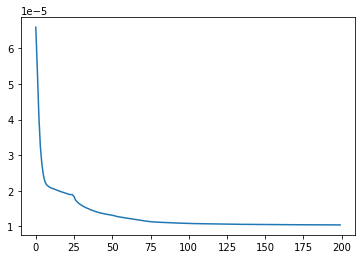

In [127]:
plt.plot(hist.history['loss'])
print(hist.history['loss'])




In [176]:
e = iter(x_train).next()


# Create a heatmap-like visualization using Plotly
fig = px.imshow(e[0], color_continuous_scale='viridis', aspect= "auto")
fig.update_layout(title='2D Tensor as Image (TensorFlow)')
fig.update_xaxes(title_text='genes (normalized)')
fig.update_yaxes(title_text='timestamps')
fig.update_traces(showscale=True)

fig.show()


In [175]:
z = autoencoder.encoder(e)

# Reshape the 1D tensor to have a single row (1x64)
tensor_reshaped = z[0].reshape(1, -1)

# Create a heatmap-like visualization using Plotly
fig = px.imshow(tensor_reshaped, color_continuous_scale='viridis', aspect= "auto")
fig.update_layout(title='2D Tensor as Image (TensorFlow)')
fig.update_xaxes(title_text='latent representation')
fig.update_traces(showscale=True)

fig.show()

In [177]:
decoded = autoencoder.decoder(z)
#print(decoded[0])

# Create a heatmap-like visualization using Plotly
fig = px.imshow(decoded[0], color_continuous_scale='viridis', aspect= "auto")
fig.update_layout(title='2D Tensor as Image (TensorFlow)')
fig.update_xaxes(title_text='genes (normalized)')
fig.update_yaxes(title_text='timestamps')
fig.update_traces(showscale=True)

fig.show()

In [130]:
autoencoder.encoder.save('../workfiles/cnn_autoencoer_model')


INFO:tensorflow:Assets written to: ../workfiles/cnn_autoencoer_model/assets


INFO:tensorflow:Assets written to: ../workfiles/cnn_autoencoer_model/assets


In [131]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

5/5 [==============================] - 0s 23ms/step


In [132]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [133]:
df.to_csv("../workfiles/compressed_data_cnn.csv", index = False)
